In [1]:
using Keldysh; kd = Keldysh
using KeldyshED; ked = KeldyshED; op = KeldyshED.Operators

using QInchworm.utility: ph_conj
using QInchworm.expansion: Expansion, InteractionPair, add_corr_operators!
using QInchworm.inchworm: inchworm!, correlator_2p
using QInchworm.ppgf: partition_function, normalize!, density_matrix

In [2]:
β = 1.0

nt = 10
ntau = 4
tmax = 1.0

ϵ = 0.1     # Position of the atomic level
U = 1.0     # Coulomb repulsion constant
D = 2.0     # Half-bandwidth of the bath DOS
V = 0.5     # Coupling strength between the atom and the bath

0.5

In [3]:
contour = kd.twist(kd.FullContour(β=β, tmax=tmax))
grid = kd.FullTimeGrid(contour, nt, ntau);

In [4]:
H_at = ϵ * (op.n("up") + op.n("dn")) + U * op.n("up") * op.n("dn")
soi = ked.Hilbert.SetOfIndices([["up"], ["dn"]])
ed = ked.EDCore(H_at, soi)

Dimension of full Hilbert space: 4
Number of invariant subspaces: 4
  Subspace 1, dim = 1
    Basis Fock states: UInt64[0x0000000000000000]
    Energy levels: [0.0]
  Subspace 2, dim = 1
    Basis Fock states: UInt64[0x0000000000000001]
    Energy levels: [0.1]
  Subspace 3, dim = 1
    Basis Fock states: UInt64[0x0000000000000002]
    Energy levels: [0.1]
  Subspace 4, dim = 1
    Basis Fock states: UInt64[0x0000000000000003]
    Energy levels: [1.2]
Ground state energy: 0.0


In [5]:
bath_dos = kd.bethe_dos(t=D/2)
Δ = V^2 * kd.TimeInvariantFullTimeGF(bath_dos, grid)

int_pairs = [
    InteractionPair(op.c_dag("up"), op.c("up"), Δ),
    #InteractionPair(op.c("up"), op.c_dag("up"), ph_conj(Δ)),
    InteractionPair(op.c("up"), op.c_dag("up"), Δ), # Fix Me!
    InteractionPair(op.c_dag("dn"), op.c("dn"), Δ),
    #InteractionPair(op.c("dn"), op.c_dag("dn"), ph_conj(Δ))
    InteractionPair(op.c("dn"), op.c_dag("dn"), Δ) # Fix Me!
    ]

expansion = Expansion(ed, grid, int_pairs);

In [6]:
@show typeof(expansion.P)

typeof(expansion.P) = Vector{GenericTimeGF{ComplexF64, false, FullTimeGrid}}


Vector{GenericTimeGF{ComplexF64, false, FullTimeGrid}} (alias for Array{GenericTimeGF{Complex{Float64}, false, FullTimeGrid}, 1})

In [7]:
using PyPlot; plt = PyPlot

PyPlot

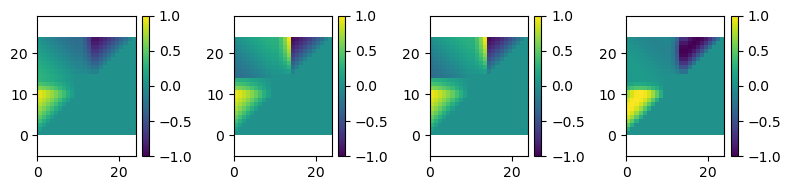

In [8]:
ns = length(expansion.P)
subp = [1, ns, 1]
plt.figure(figsize=(8, 2))

for s in 1:ns
    plt.subplot(subp...); subp[end] += 1
    plt.pcolormesh(real(expansion.P[s].data[1, 1, :, :]), vmin=-1, vmax=+1)
    plt.colorbar()
    plt.axis("equal")
end
plt.tight_layout()

In [9]:
norb_s = [ norbitals(p) for p in expansion.P ]
Σ = [ kd.TimeInvariantFullTimeGF(grid, norb) for norb in norb_s ];

In [30]:
function ppsc_sigma_nca!(Σ, G, expansion, t, τ);

    for (s, Σ_s) in enumerate(Σ)

        Σ_s[:, :, t, τ] .= 0.

        for (pidx, (pair, op_mats)) in enumerate(zip(expansion.pairs, expansion.pair_operator_mat))
            Δ = pair.propagator
            O1, O2 = op_mats
        
            haskey(O2, s) || continue 
            
            s_2, mat2 = O2[s]
            s_1, mat1 = O1[s_2]
            @assert s_1 == s

            Σ_s[:, :, t, τ] += mat1 * G[s_2][:, :, t, τ] * mat2 * Δ[t, τ]
            Σ_s[:, :, t, τ] += mat2 * G[s_2][:, :, t, τ] * mat1 * Δ[τ, t]
        end
    end
end;

In [37]:
t = first(grid[forward_branch])
τ = first(grid[imaginary_branch])

ppsc_sigma_nca!(Σ, expansion.P, expansion, t, τ)

In [36]:
s = 1
for z in grid
    # -- todo extend atomic ppgf
    @assert expansion.P[s][:, :, z, z] == expansion.P0[s][z, z] 
end

LoadError: MethodError: no method matching getindex(::QInchworm.exact_atomic_ppgf.ExactAtomicPPGF, ::Colon, ::Colon, ::TimeGridPoint, ::TimeGridPoint, ::Bool)

[0mClosest candidates are:
[0m  getindex(::AbstractTimeGF{T, false}, [91m::TimeGridPoint[39m, [91m::TimeGridPoint[39m, ::Any) where T
[0m[90m   @[39m [36mKeldysh[39m [90m~/.julia/packages/Keldysh/aL7kP/src/[39m[90m[4mgf.jl:26[24m[39m
[0m  getindex(::AbstractTimeGF{T, false}, [91m::TimeGridPoint[39m, [91m::TimeGridPoint[39m) where T
[0m[90m   @[39m [36mKeldysh[39m [90m~/.julia/packages/Keldysh/aL7kP/src/[39m[90m[4mgf.jl:26[24m[39m
[0m  getindex(::AbstractTimeGF, [91m::BranchEnum[39m, [91m::BranchEnum[39m)
[0m[90m   @[39m [36mKeldysh[39m [90m~/.julia/packages/Keldysh/aL7kP/src/[39m[90m[4mgf.jl:30[24m[39m
[0m  ...


# To DO

- `ph_conj` - extend for real-time GF
- `exact_atomic_ppgf` - extend eval support to all times
- Hybridization function update
- Imaginary time DMFT self consistent setup